<a href="https://colab.research.google.com/github/v-zeng/python_projects/blob/main/time_series_forecasting_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **XGBoost for Time Series Forecasting**

In [ ]:
# Dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight') # utilize fivethirtyeight.com styles

In [ ]:
# read in data, set datetime as index
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) # convert index type to datetime

In [ ]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


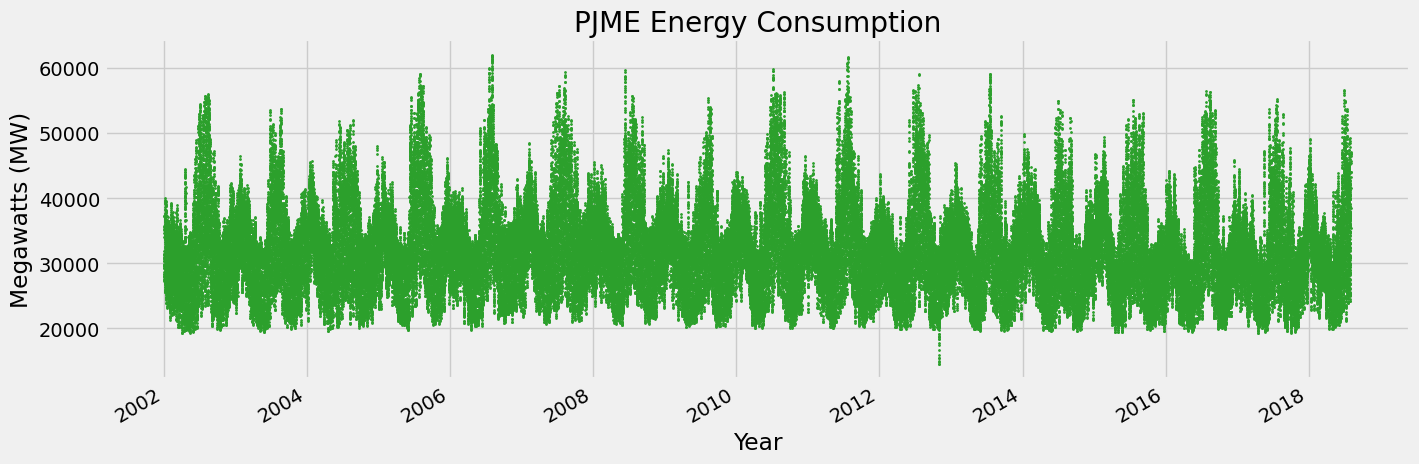

In [ ]:
# visualize data
df.plot(style='.',
        markersize='2',
        figsize=(15,5),
        color=color_palette[2],
        title='PJME Energy Consumption',
        xlabel='Year',
        ylabel='Megawatts (MW)',
        legend=False)
plt.show()
# note the outliers near 2013, consider removing

## Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

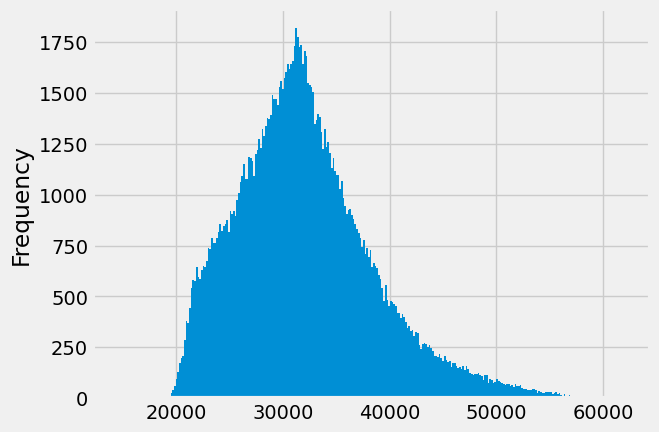

In [ ]:
# create histogram of megawatt (MW) data
df.columns
df['PJME_MW'].plot(kind='hist', bins=300)

<Axes: xlabel='Datetime'>

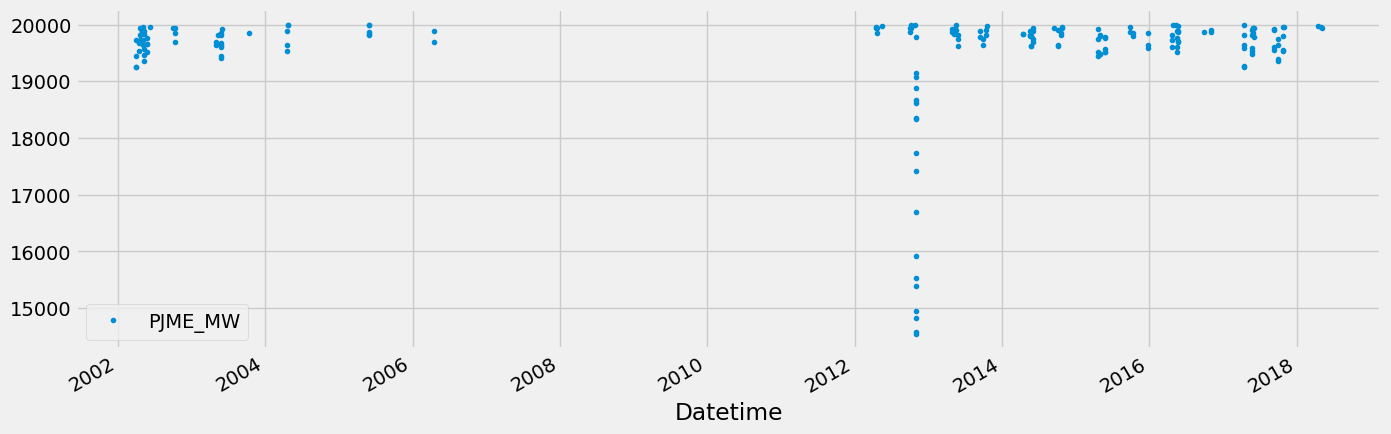

In [ ]:
# check for outliers < 20000 MW
df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.')
# the outliers < 19000 MW do not look like relatively legitimate data

<Axes: xlabel='Datetime'>

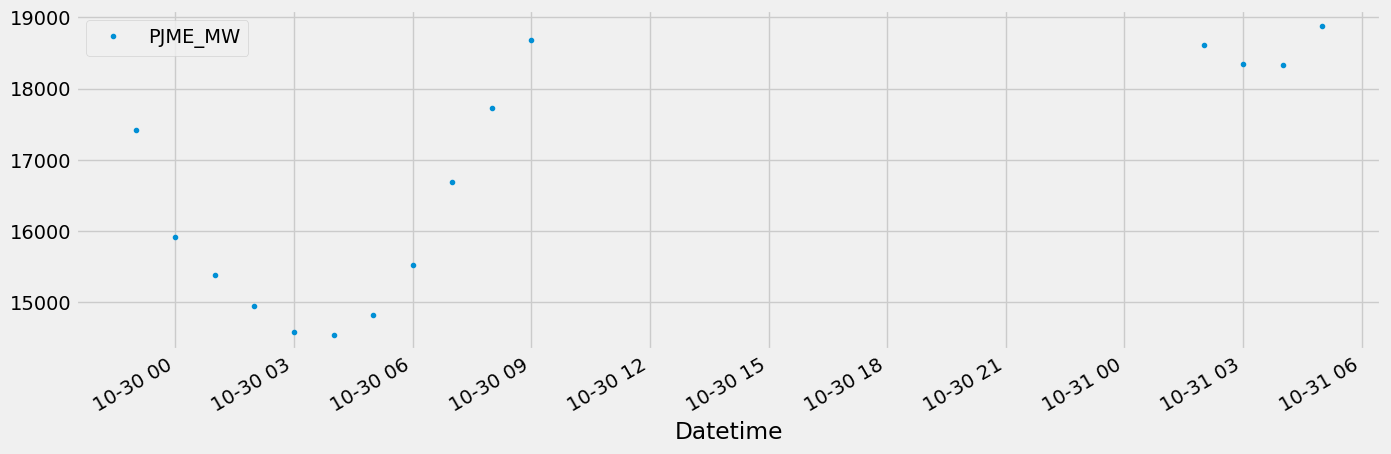

In [ ]:
# change to better threshold for outliers < 19000 MW
df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')

In [ ]:
# this is one way to filter out the outliers
df = df.query('PJME_MW > 19_000').copy()

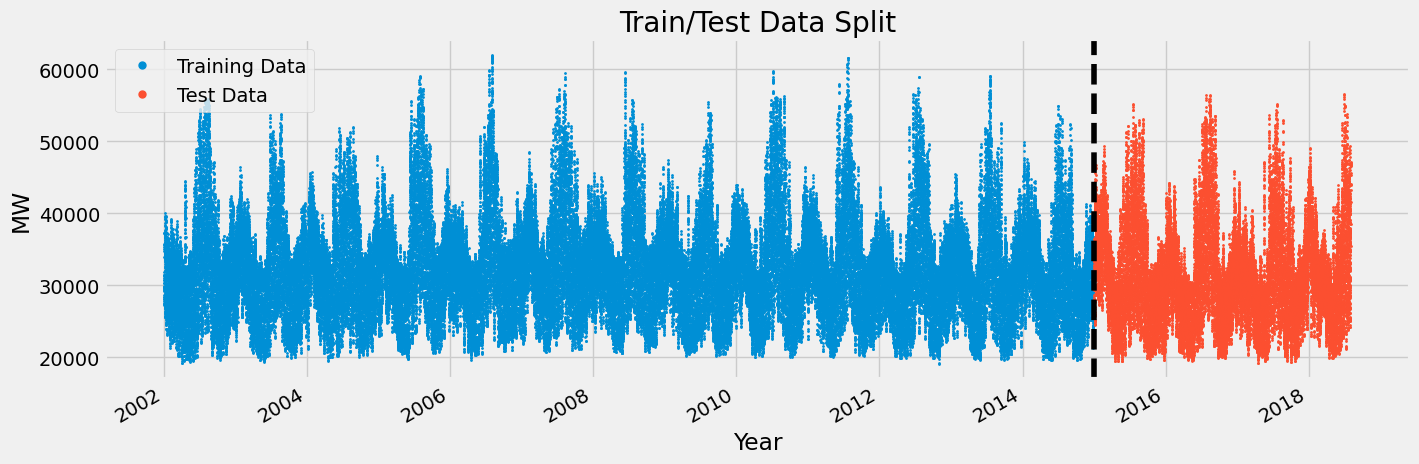

In [ ]:
# Train test split
train = df.loc[df.index < '01-01-2015'] # use pre-2015 data to training set
test = df.loc[df.index >= '01-01-2015'] # 2015 onwards for test set
# visualize train and test
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,
           label='Training Set',
           style='.',
           markersize='2',
           title='Train/Test Data Split',
           ylabel='MW',
           xlabel='Year')
test.plot(ax=ax,
          label='Test Set',
          style='.',
          markersize='2',
          ylabel='MW',
          xlabel='Year')
ax.axvline('01-01-2015', color='black', ls='--') # dotted line show train/test split
# increase marker size in legend
ax.legend(['Training Data', 'Test Data'], markerscale=5)
plt.show()

## Train Test Split

Datetime
2010-01-01       Friday
2010-01-02     Saturday
2010-01-03       Sunday
2010-01-04       Monday
2010-01-05      Tuesday
2010-01-06    Wednesday
2010-01-07     Thursday
2010-01-08       Friday
Freq: D, Name: Datetime, dtype: object


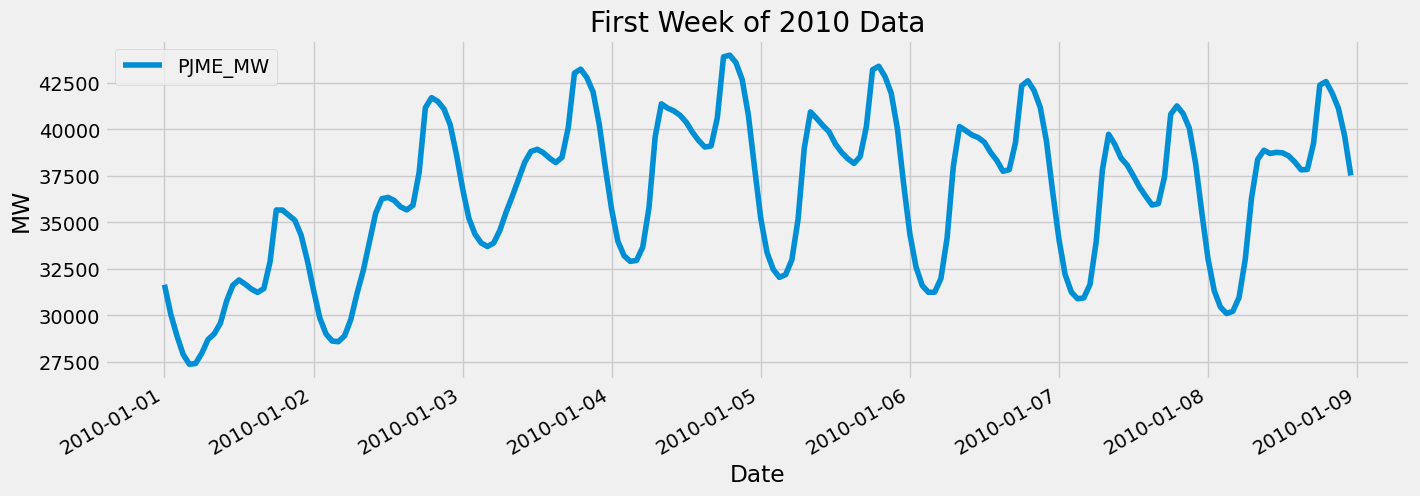

In [ ]:
# inspect data from a week slice
week_slice = df.loc['01-01-2010':'01-08-2010']
# determine days observed for the week
week_slice_daily = week_slice.resample('D').sum() # resample first week of 2010 to daily sum of energy usage
days = week_slice_daily.index.to_series().dt.day_name() # convert index to series and apply transformation
print(days)
# visualize train test data
week_slice.plot(figsize=(15,5),
                title='First Week of 2010 Data',
                ylabel='MW',
                xlabel='Date')
plt.show()
# note the peaks and valleys for energy consumption during a day within the week

## TIme Series Cross-Validation with sklearn

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# test size: predict out into the future 1 year = 365 days, 24 hours per day
# gap between training and validation sets = 24 (hours)
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
# sort df on index
df = df.sort_index()

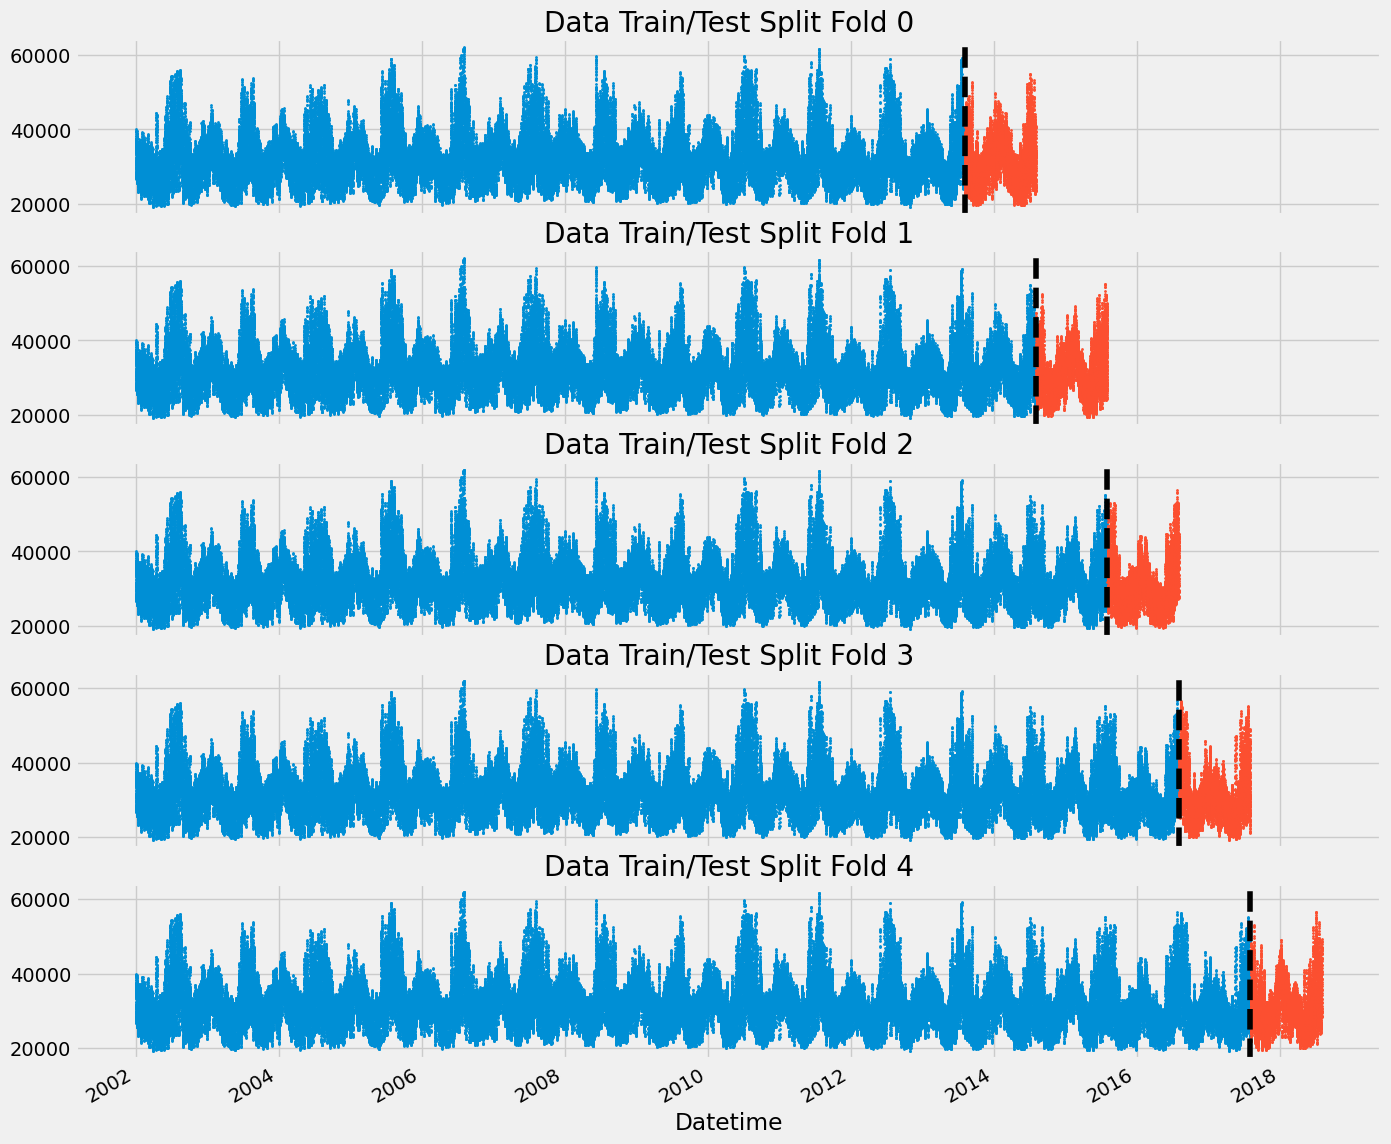

In [ ]:
# visualize tss with matplotlib subplot, make one subplot for each split
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
# track fold, increment fold
fold = 0


for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['PJME_MW'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}',
                        style='.',
                        markersize='2')
  test['PJME_MW'].plot(ax=axs[fold],
                       label='Test Set',
                       style='.',
                       markersize='2')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1


plt.show()

## Feature Creation and Forecasting Horizon

In [ ]:
# feature creation function
def create_features(df):
  ''' Create features for time series based on index'''
  df = df.copy() # edit copy of df
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

In [ ]:
# apply feature creation function to df
df = create_features(df)

## Visualize Data: Feature/Target Correlation

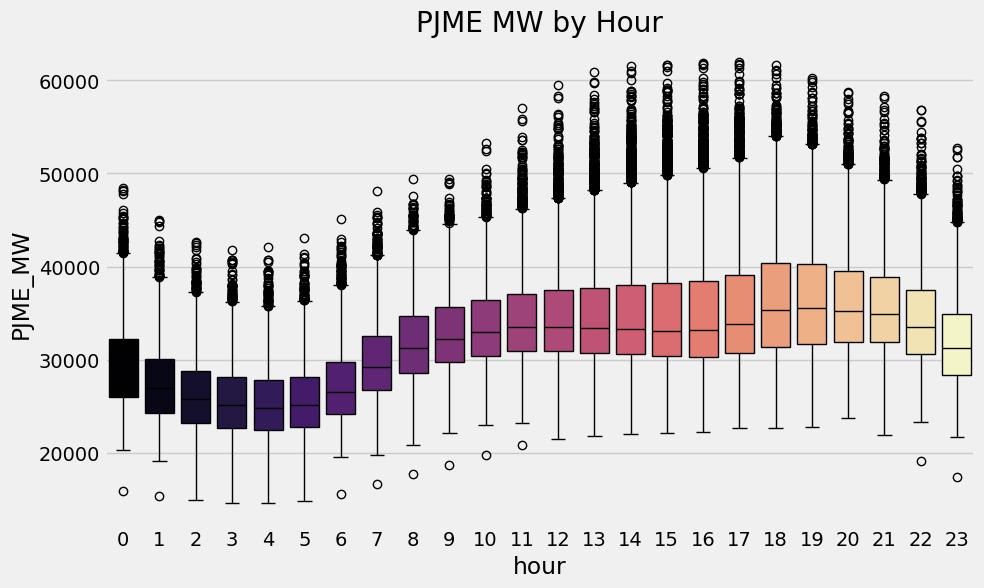

In [ ]:
# use boxplot to investigate distribution of hourly data
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('PJME MW by Hour')
sns.boxplot(data=df,
            x='hour',
            y='PJME_MW',
            palette='magma',
            hue='hour',
            legend=False)
plt.show()
# energy use dips early in morning, increases towards evening

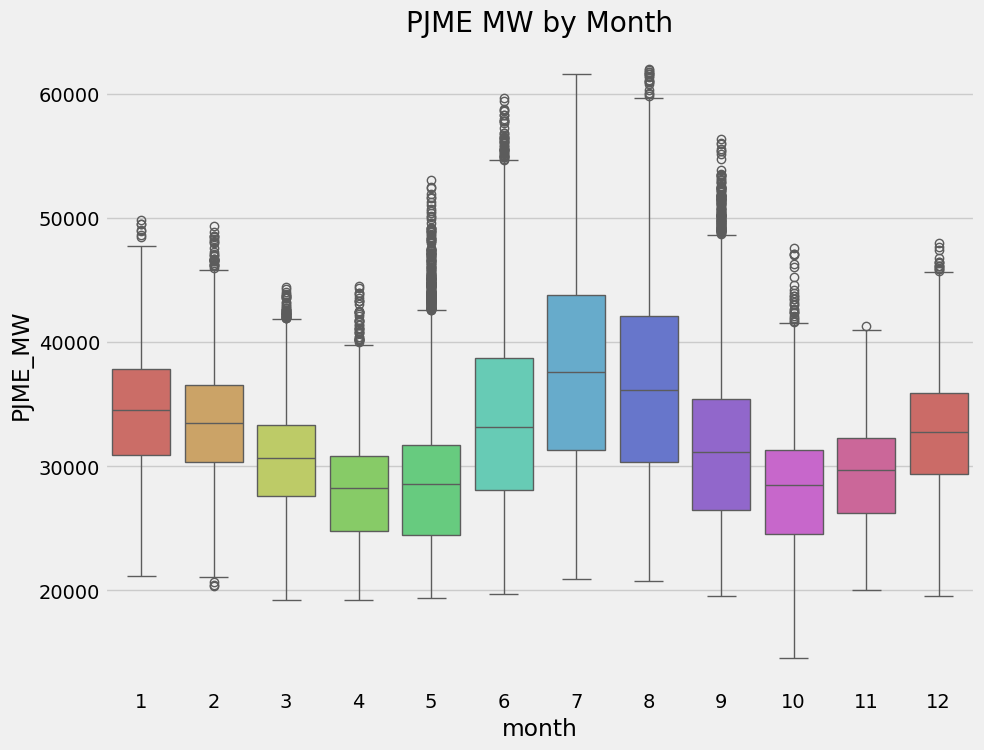

In [ ]:
# use boxplot to investigate distribution of monthly data
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('PJME MW by Month')
sns.boxplot(data=df,
            x='month',
            y='PJME_MW',
            palette='hls',
            hue='month',
            legend=False)
plt.show()
# energy consumption peaks in winter and summer, dips in spring and fall

## Build Model

In [ ]:
# check feature and target names
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [ ]:
# create features for train and test
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# grid search
model = XGBRegressor()
n_estimators = [400, 600, 800]
learning_rate = [0.01, 0.05, 0.1]
param_grid = dict(n_estimators=n_estimators,
                  learning_rate=learning_rate)
kfold = KFold(n_splits=10, shuffle=False)
grid_search = GridSearchCV(model,
                           param_grid,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
# summarize results
# Best: 3261.292554 using {'learning_rate': 0.01, 'n_estimators': 400}
print("Best: %f using %s" % (abs(grid_result.best_score_),
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (abs(mean), stdev, param))

Best: 3261.292554 using {'learning_rate': 0.01, 'n_estimators': 400}
3261.292554 (225.708941) with: {'learning_rate': 0.01, 'n_estimators': 400}
3286.691111 (223.447539) with: {'learning_rate': 0.01, 'n_estimators': 600}
3353.386958 (288.467457) with: {'learning_rate': 0.01, 'n_estimators': 800}
3651.542590 (485.773418) with: {'learning_rate': 0.05, 'n_estimators': 400}
3770.861843 (514.221405) with: {'learning_rate': 0.05, 'n_estimators': 600}
3828.211298 (515.597021) with: {'learning_rate': 0.05, 'n_estimators': 800}
3773.056478 (353.067679) with: {'learning_rate': 0.1, 'n_estimators': 400}
3843.929548 (344.853529) with: {'learning_rate': 0.1, 'n_estimators': 600}
3901.091787 (333.725887) with: {'learning_rate': 0.1, 'n_estimators': 800}


Text(0, 0.5, 'RMSE')

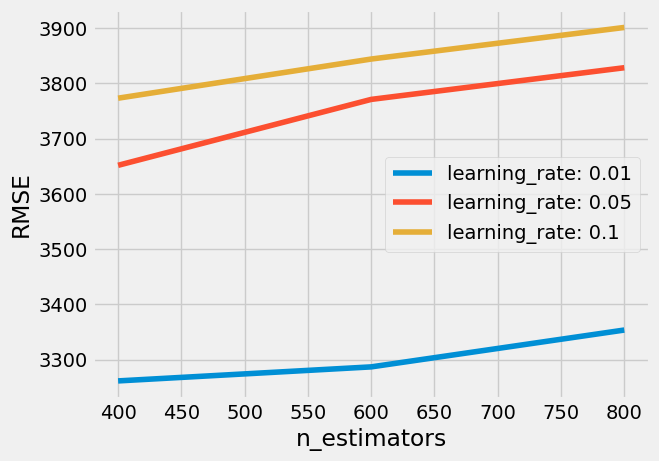

In [ ]:
# plot results
scores = np.array(abs(means)).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
  plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
# plt.savefig('n_estimators_vs_learning_rate.png')

In [ ]:
# take best estimator and retrain on full train dataset since CV is k-1
# could use something like grid_search.best_estimator_.predict(X) as well
model = XGBRegressor(booster='gbtree',
                          n_estimators=400,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=6,
                          learning_rate=0.01)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test,y_test)],
          verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:48:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.83677
[399]	validation_0-rmse:2830.76208	validation_1-rmse:3745.11750


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

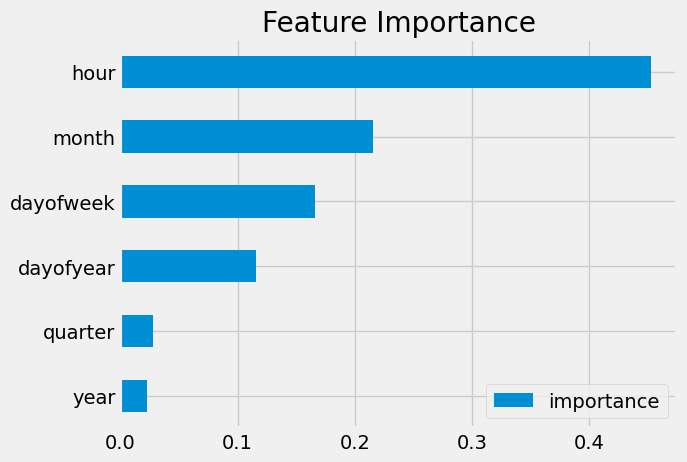

In [ ]:
# plot feature importance for visual comprehension
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
# note: some of these features are highly correlated, consider dropping

## Forecast on Test Data

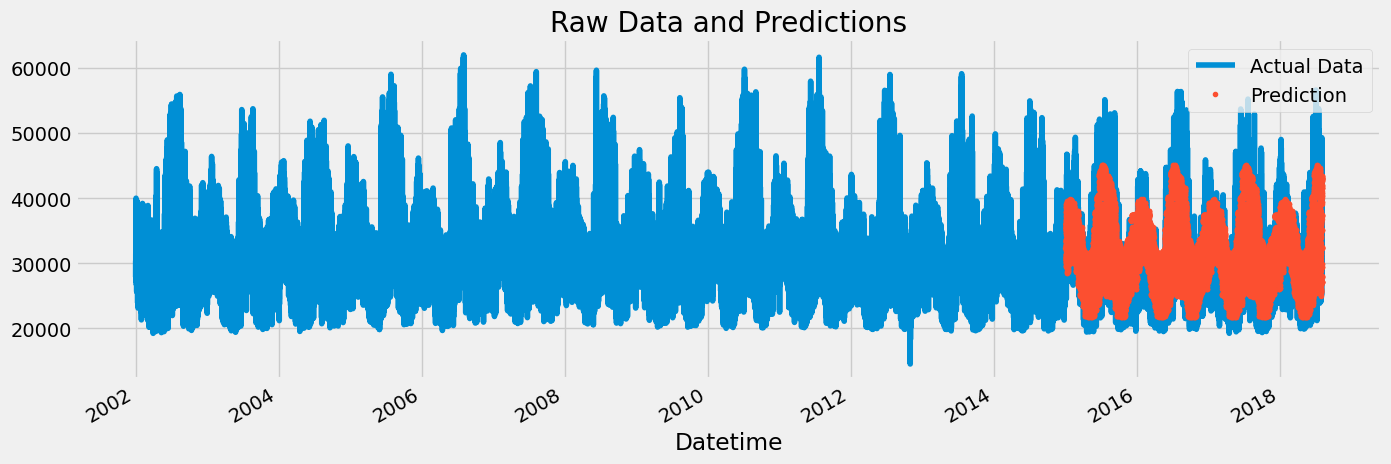

In [ ]:
# store predictions in new column
test['prediction'] = model.predict(X_test)
# merge predictions column to test set on index columns
df = df.merge(test[['prediction']],
              how='left',
              left_index=True,
              right_index=True)
# plot PJME raw data and overlay predictions
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Prediction'])
ax.set_title('Raw Data and Predictions')
plt.show()

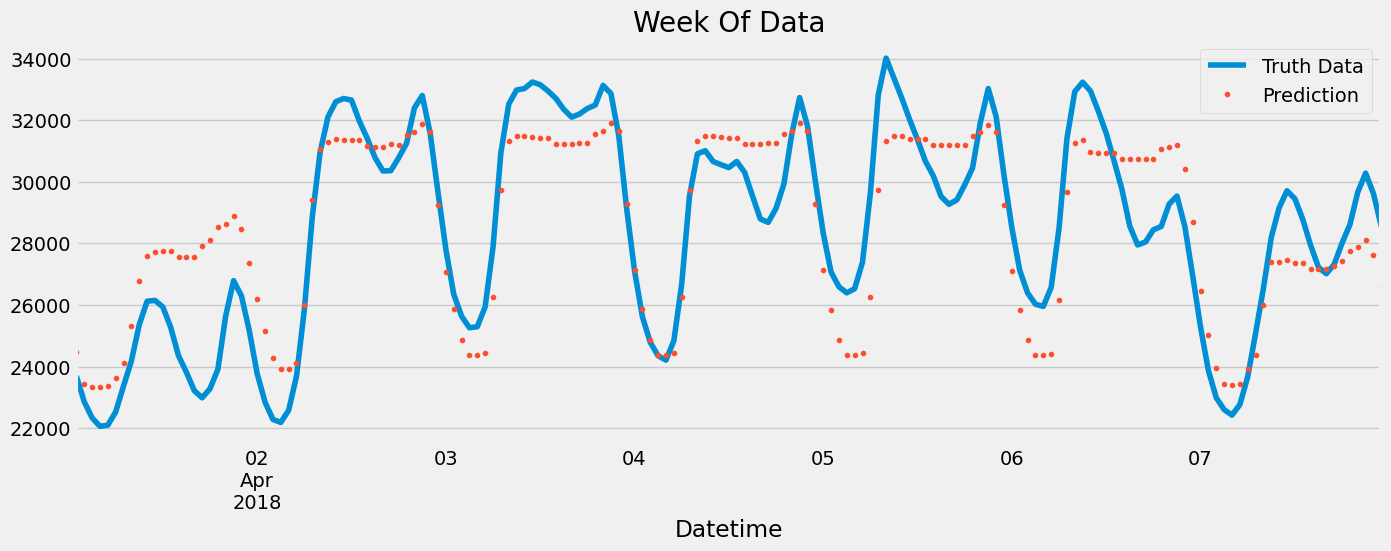

In [ ]:
# examine one week of predictions
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
# calculate RMSE on test set
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}') # 3741.16
# need to reduce this score

RMSE Score on Test set: 3741.16


In [ ]:
# examine dates for worst and best predicted energy consumptions
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)
# worst predicted dates appear to be mostly in august and september

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64